# FashioNet ver.2

## Code

In [89]:
import os
import h5py
from PIL import Image
import operator

import matplotlib.pyplot as plt
import time, pickle, pandas

import numpy as np

import tensorflow.keras
from PIL import Image
import glob

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D ,Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers import Input
from keras.applications import VGG16
from keras import backend
from keras import optimizers
from tensorflow.keras import applications
from keras.utils.conv_utils import convert_kernel


%matplotlib inline

In [90]:
import tensorflow as tf
config = tf.ConfigProto()

config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

In [91]:
# Declaring the no of classes for the category
nb_classes = 5
class_name = {
    
    0: 'Casual',
    1: 'Formal',
    2: 'Party',
    3: 'Sports',
    4: 'Vacance'
    
}

In [92]:
def show_sample(X, y, prediction=-1):
    im = X
    plt.imshow(im)
    if prediction >= 0:
        plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))
    else:
        plt.title("Class = %s" % (class_name[y]))

    plt.axis('on')
    plt.show()

In [93]:
img_width, img_height = 150, 150

train_data_dir = './Classification/style/train'
validation_data_dir = './Classification/style/val'

In [94]:
train_datagen = ImageDataGenerator(
        rescale=1./255        
        )

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=5,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=5,
        class_mode='categorical')

Found 6334 images belonging to 5 classes.
Found 2140 images belonging to 5 classes.


In [95]:
nb_train_samples = 6334
nb_validation_samples = 2140

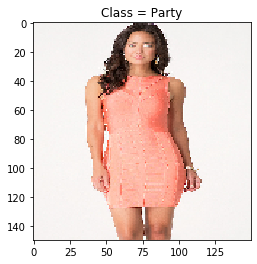

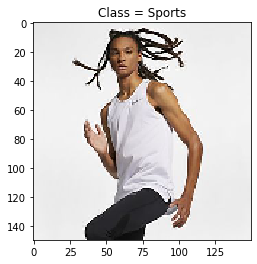

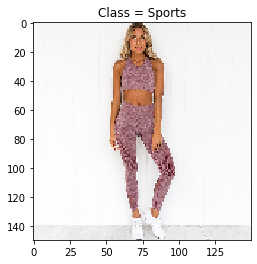

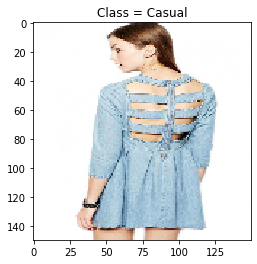

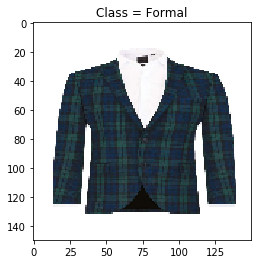

In [96]:
import PIL
from PIL import Image
from IPython.display import display


for X_batch, Y_batch in train_generator:
    for i in range(5):
        show_sample(X_batch[i, :, :, :], np.argmax(Y_batch[i]))
    break

In [97]:
def build_vgg16(framework='tf'):

    if framework == 'th':
         backend.set_image_dim_ordering('th')        
    else:
         backend.set_image_dim_ordering('tf')
        
    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    else:
        model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))
        
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

weights_path = 'vgg16_weights.h5'
th_model = build_vgg16('th')

assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(th_model.layers):
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    
f.close()
print('Model loaded.')

tf_model = build_vgg16('tf')

for th_layer, tf_layer in zip(th_model.layers, tf_model.layers):
        tf_layer.set_weights(tf_layer.get_weights())
    
top_model = Sequential()
print (Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Flatten(input_shape=tf_model.output_shape[1:]))
top_model.add(Dense(512, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(5, activation='softmax'))
print (tf_model.summary())
print(top_model.summary())

/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_1")`
  
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", name="conv1_2")`
  app.launch_new_instance()
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_1")`
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), activation="relu", name="conv2_2")`
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: UserWarning: Update your `C

Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_144 (ZeroPadd (None, 152, 152, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 150, 150, 64)      1792      
_________________________________________________________________
zero_padding2d_145 (ZeroPadd (None, 152, 152, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 150, 150, 64)      36928     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
zero_padding2d_146 (ZeroPadd (None, 77, 77, 64)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 75, 75, 128)       73856  

In [98]:
# add the model on top of the convolutional base
tf_model.add(top_model)

In [99]:
#Freezing the weights of all layers except top

for layer in tf_model.layers[:-4]:
    layer.trainable = False
    
#Using an Adam optimizer with lower learning rate
adam1=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
tf_model.compile(optimizer = adam1, loss = 'categorical_crossentropy', metrics=['accuracy'])


In [100]:
#Training the model for 5 epochs

checkpoint_callback = ModelCheckpoint('./models/vgg_weights_frozen_style.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = 5,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = 0,
        callbacks=[checkpoint_callback]
)

/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  del sys.path[0]
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., verbose=1, initial_epoch=0, callbacks=[<keras.ca..., steps_per_epoch=1266, epochs=5, validation_steps=2140)`
  del sys.path[0]


Epoch 1/5
1266/1266 [==============================] - 120s 95ms/step - loss: 1.5814 - acc: 0.2546 - val_loss: 1.5314 - val_acc: 0.3416
Epoch 2/5
1266/1266 [==============================] - 116s 91ms/step - loss: 1.4844 - acc: 0.3494 - val_loss: 1.4498 - val_acc: 0.3930
Epoch 3/5
1266/1266 [==============================] - 115s 91ms/step - loss: 1.4094 - acc: 0.4049 - val_loss: 1.3933 - val_acc: 0.4075
Epoch 4/5
1266/1266 [==============================] - 115s 91ms/step - loss: 1.3697 - acc: 0.4285 - val_loss: 1.4077 - val_acc: 0.3986
Epoch 5/5
1266/1266 [==============================] - 115s 91ms/step - loss: 1.3365 - acc: 0.4551 - val_loss: 1.3478 - val_acc: 0.4533


In [101]:
accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
        break
       
print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

Validation: accuracy = 0.430000  ;  loss = 1.318942


In [102]:
#unfreezing the layers and recompiling the model 

for layer in tf_model.layers[:-4]:
    layer.trainable = True
    
#Using an Adam optimizer with lower learning rate
adam1=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
tf_model.compile(loss = 'categorical_crossentropy', optimizer = adam1, metrics=['accuracy'])

In [103]:
#Loading weights with the best validation accuracy
tf_model.load_weights('./models/vgg_weights_frozen_style.hdf5')

In [104]:
#Training the whole network for 5 epochs first
checkpoint_callback = ModelCheckpoint('./models/vgg_weights_best_style.hdf5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)

tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = 10,
        validation_data = validation_generator,
        nb_val_samples = nb_validation_samples,
        verbose = 1,
        initial_epoch = 5,
        callbacks=[checkpoint_callback]
)

/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=<keras_pre..., verbose=1, initial_epoch=5, callbacks=[<keras.ca..., steps_per_epoch=1266, epochs=10, validation_steps=2140)`
  if sys.path[0] == '':


Epoch 6/10
1266/1266 [==============================] - 135s 106ms/step - loss: 1.4977 - acc: 0.3465 - val_loss: 1.3964 - val_acc: 0.4237
Epoch 7/10
1266/1266 [==============================] - 134s 106ms/step - loss: 1.3042 - acc: 0.4769 - val_loss: 1.4641 - val_acc: 0.4358
Epoch 8/10
1266/1266 [==============================] - 134s 106ms/step - loss: 1.2078 - acc: 0.5366 - val_loss: 1.2762 - val_acc: 0.4891
Epoch 9/10
1266/1266 [==============================] - 134s 106ms/step - loss: 1.1234 - acc: 0.5733 - val_loss: 1.2023 - val_acc: 0.5221
Epoch 10/10
1266/1266 [==============================] - 135s 106ms/step - loss: 1.0398 - acc: 0.6062 - val_loss: 1.2385 - val_acc: 0.5336


In [105]:
accuracies = np.array([])
losses = np.array([])

i=0
for X_batch, Y_batch in validation_generator:
    loss, accuracy = tf_model.evaluate(X_batch, Y_batch, verbose=0)
    losses = np.append(losses, loss)
    accuracies = np.append(accuracies, accuracy)
    i += 1
    if i == 20:
        break

print("Validation: accuracy = %f  ;  loss = %f" % (np.mean(accuracies), np.mean(losses)))

Validation: accuracy = 0.570000  ;  loss = 1.140303


In [106]:
tf_model.fit_generator(
        train_generator,
        samples_per_epoch = nb_train_samples,
        nb_epoch = 13,
        validation_steps = 4000,
        validation_data = validation_generator,
        verbose = 1,
        initial_epoch = 10,
        callbacks=[checkpoint_callback]
)

Epoch 11/13
   2/1266 [..............................] - ETA: 1:34 - loss: 0.9940 - acc: 0.7000

/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if __name__ == '__main__':
/home/rtcl/Deep-fashion/Deep-fashion-venv/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_steps=4000, validation_data=<keras_pre..., verbose=1, initial_epoch=10, callbacks=[<keras.ca..., steps_per_epoch=1266, epochs=13)`
  if __name__ == '__main__':


1266/1266 [==============================] - 198s 156ms/step - loss: 0.9605 - acc: 0.6486 - val_loss: 1.0784 - val_acc: 0.5771
Epoch 12/13
1266/1266 [==============================] - 198s 156ms/step - loss: 0.8629 - acc: 0.6806 - val_loss: 1.0477 - val_acc: 0.5900
Epoch 13/13
1266/1266 [==============================] - 198s 157ms/step - loss: 0.7871 - acc: 0.7051 - val_loss: 1.0235 - val_acc: 0.6076


Now the best model for pattern is saved in an hdf5 file. We do a similar run for all the categories of features and get models for each of those. 